In [38]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
import numpy as np

In [47]:
# Load the tracking data
# Replace with the correct file path
tracking_data = pd.read_csv('tracking_week_1.csv')  
plays_data = pd.read_csv('plays.csv')

# Filter data for a specific play
game_id = 2022091104  # Replace with your desired gameId
play_id = 803         # Replace with your desired playId

# Merge tracking data with play data to include `yardsToGo`
tracking_data = tracking_data.merge(
    plays_data[['gameId', 'playId', 'yardsToGo', 'quarter', 'gameClock', 'down']],
    on=['gameId', 'playId'],
    how='left'
)

play_data = tracking_data[(tracking_data['gameId'] == game_id) & (tracking_data['playId'] == play_id)]

In [40]:
# Get starting ball position and first down marker
ball_start = play_data[play_data['frameId'] == 1].loc[play_data['nflId'].isna(), 'x'].values[0]
first_down_marker = ball_start + play_data['yardsToGo'].iloc[0]

In [41]:
# Separate ball and player data
ball_data = play_data[play_data['nflId'].isna()]
player_data = play_data[play_data['nflId'].notna()]

In [48]:
def draw_field(ax):
    # Draw field border
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)
    ax.set_facecolor("green")
    ax.set_title(f"Play {play_id} - Game {game_id}")

    # Draw yard lines
    for x in range(0, 121, 10):
        ax.axvline(x=x, color="white", linestyle="-", linewidth=0.5)
        if x > 10 and x < 110:  # Skip the end zones
            ax.text(x, 1, str(x - 10), color="white", fontsize=8, ha="center")

    # Draw hash marks
    for y in [23.6, 29.7]:  # Hash marks positions
        ax.hlines(y, xmin=0, xmax=120, color="white", linestyle="--", linewidth=0.5)

    # Add the starting position of the ball
    ax.axvline(x=ball_start, color="black", linestyle="-", linewidth=2, label="Line of Scrimmage")

    # Add the first down line
    ax.axvline(x=first_down_marker, color="yellow", linestyle="--", linewidth=2, label="First Down Line")


In [43]:
# Initialize the field
def init_field():
    fig, ax = plt.subplots(figsize=(12, 7))
    draw_field(ax)
    return fig, ax

In [53]:
# Update function for animation
def update(frame_id):
    ax.clear()
    draw_field(ax)

    # Filter data for the current frame
    frame_data = play_data[play_data['frameId'] == frame_id]
    ball = frame_data[frame_data['nflId'].isna()]
    players = frame_data[frame_data['nflId'].notna()]

    # Plot ball
    ax.scatter(ball['x'], ball['y'], c='brown', s=200, label='Ball')

    # Plot players with teams
    teams = players.groupby('club')
    for team, group in teams:
        ax.scatter(group['x'], group['y'], label=team)
        for _, player in group.iterrows():
            # Convert jersey numbers to integers
            jersey_number = int(player['jerseyNumber'])
            ax.text(player['x'], player['y'], str(jersey_number), fontsize=8, ha='center', va='center')

    play_info = (
        f"Quarter: {play_data.quarter.iloc[0]} | Game Clock: {play_data.gameClock.iloc[0]} \n"
        f"Down: {play_data.down.iloc[0]} | Yards to Go: {play_data.yardsToGo.iloc[0]}"
    )
    ax.text(5, 50, play_info, fontsize = 10, color = 'white', bbox=dict(facecolor="black", alpha=0.8, boxstyle="round"))

    ax.legend(loc='upper right')

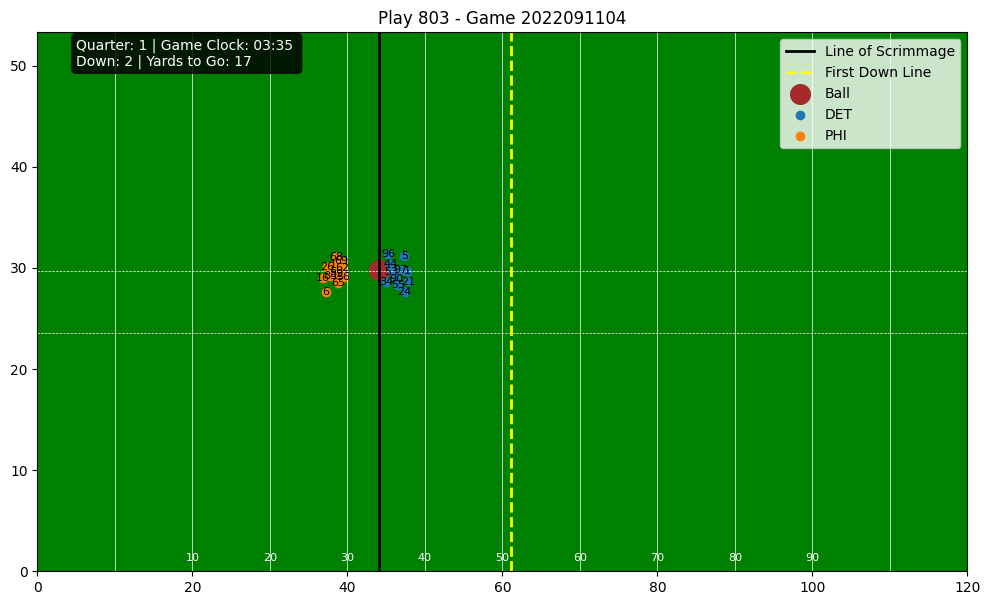

In [54]:
# Create animation
fig, ax = init_field()
frames = sorted(play_data['frameId'].unique())
ani = FuncAnimation(fig, update, frames=frames, repeat=False)

In [55]:
# Save animation or show it
ani.save('play_animation.mp4', writer='ffmpeg', fps=10)  # Save as video
plt.show()  # Display the animation